# Guided example of a backreaction study

Backreaction is a complex interaction that arises from the exchange of angular momentum between gas and dust.
In order for backreaction to be effective the dust-to-gas ratios need to be high, and the Stokes number of the grains (i.e. their dynamical size) large.

In this guided example we will learn how to quantify the dynamical effect of the backreaction, by looking at the gas surface density, gas radial velocity, and the back-reaction coefficients in three simulations:

* One simulation without backreaction and ISM dust-to-gas ratio ($\epsilon_0 = 1\%$)
* One simulation with backreaction and ISM dust-to-gas ratio ($\epsilon_0 = 1\%$)
* One simulation with backreaction, a high dust-to-gas ratio ($\epsilon_0 = 5\%$), and a snowline


In [1]:
import numpy as np
from dustpy import Simulation
from dustpy import constants as c

from dustpylib.dynamics.backreaction import setup_backreaction

## Running the simulations

To simplify this notebook, we will define a routine that creates and initializes a standard simulation object, with custom initial dust-to-gas ratio:

In [2]:
def get_Simulation(d2gRatio = 0.01):
    sim = Simulation()

    
    # Relevant Gas and Dust parameters
    sim.ini.gas.gamma = 1.0
    sim.ini.gas.alpha = 1.e-3
    sim.ini.dust.vfrag = 1000.0
    sim.ini.dust.d2gRatio = d2gRatio


    # Radial Grid Parameters
    sim.ini.grid.Nr = 200
    sim.ini.grid.rmin = 5 * c.au
    sim.ini.grid.rmax = 500 * c.au

    # Initialization and snapshots
    sim.initialize()    
    sim.t.snapshots = np.linspace(0.1, 2.0, 20) * 1.e5 * c.year
    
    
    return sim

1. We will create our first control simulation, without backreaction.

This simulation will evolve by standard viscous evolution, without any particular features.

In [3]:
sim_Control = get_Simulation(d2gRatio = 0.01)
sim_Control.writer.datadir = "./Example_Simulations/Control/"

Execute `sim_Control.run()`

2. For the second simulation we will include the basic backreaction setup, after creating the simulation object.

In [4]:
sim_Backreaction = get_Simulation(d2gRatio = 0.01)
setup_backreaction(sim_Backreaction)
sim_Backreaction.writer.datadir = "./Example_Simulations/Backreaction/"

Setting up the backreaction module.
Please cite the work of Garate(2019, 2020).


Execute `sim_Backreaction.run()`

3. For the third simulation we will create a more complex setup with an iceline (modeled as a change in the the fragmentation velocity at a certain location).

In [5]:
sim_Backreaction_Iceline = get_Simulation(d2gRatio = 0.05)
setup_backreaction(sim_Backreaction_Iceline)

r_iceline = 20 * c.au
r = sim_Backreaction_Iceline.grid.r
sim_Backreaction_Iceline.dust.v.frag[r < r_iceline] = 100.
sim_Backreaction_Iceline.update()
sim_Backreaction_Iceline.writer.datadir = "./Example_Simulations/Backreaction_Iceline/"

Setting up the backreaction module.
Please cite the work of Garate(2019, 2020).


Execute `sim_Backreaction_Iceline.run()`

## Analyzing the simulations

In [6]:
import matplotlib.pyplot as plt
from dustpy import hdf5writer
reader = hdf5writer()

We read the last snapshot in the simulation from the `Example_Simulations` folder.

(At this point we already ran the simulations through a script and saved a compact version of the output files for this notebook plotting routine).

We read the snapshot 10, which corresponds to a time of `0.1 Myr`

In [7]:
snapshot = 10
reader.datadir = sim_Control.writer.datadir
sim_Control = reader.read.output(snapshot)

reader.datadir = sim_Backreaction.writer.datadir
sim_Backreaction = reader.read.output(snapshot)

reader.datadir = sim_Backreaction_Iceline.writer.datadir
sim_Backreaction_Iceline = reader.read.output(snapshot)


In [8]:
# The radial grid is the same, so we read it here
r = sim_Control.grid.r

We start by taking a look at the gas and dust surface densities of the three simulations:

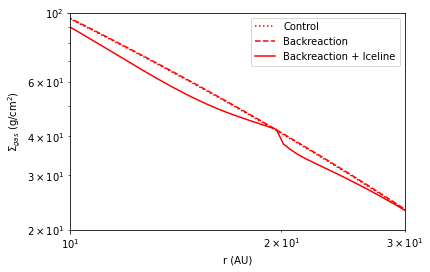

In [9]:
plt.figure()
plt.xlim([10,30])
plt.ylim([20,100])
plt.xlabel('r (AU)')
plt.ylabel(r'$\Sigma_{gas}$ (g/cm$^2$)')

plt.loglog(r/c.au, sim_Control.gas.Sigma, 'r:', label = 'Control')
plt.loglog(r/c.au, sim_Backreaction.gas.Sigma, 'r--', label = 'Backreaction')
plt.loglog(r/c.au, sim_Backreaction_Iceline.gas.Sigma, 'r-', label = 'Backreaction + Iceline')
plt.legend()

From the surface density profiles we see just about no difference between the `Control` and `Backreaction` simulations.

However we see that the gas surface density has changed when the iceline was considered in a high dust-to-gas ratio disk, creating a small bump in the disk.

Let's take a look at the gas velocities, which are now a contribution of two terms: a damped viscous accretion, and a backreaction push against the pressure gradient.

$\Large v_{r, gas} = A v_\nu + 2B v_\eta$

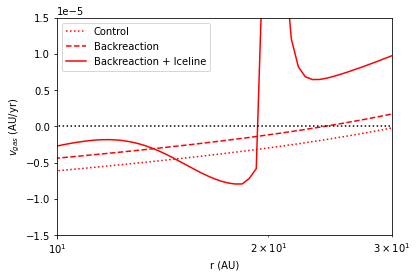

In [10]:
plt.figure()
plt.xlim([10,30])
plt.ylim([-1.5e-5,1.5e-5])
plt.xlabel('r (AU)')
plt.ylabel(r'$v_{gas}$ (AU/yr)')

plt.semilogx(r/c.au, sim_Control.gas.v.rad/(c.au/c.year), 'r:', label = 'Control')
plt.semilogx(r/c.au, sim_Backreaction.gas.v.rad/(c.au/c.year), 'r--', label = 'Backreaction')
plt.semilogx(r/c.au, sim_Backreaction_Iceline.gas.v.rad/(c.au/c.year), 'r-', label = 'Backreaction + Iceline')
plt.semilogx(r/c.au, np.zeros_like(sim_Control.grid.r), 'k:')
plt.legend()

Now the difference in the radial velocity of the gas is clear.

The the simulation with the iceline, the backreaction effect is strong enough to revert the gas flow at the snowline location, which leads to the creation of the small bump in the disk.




As a rule of thumb, the backreaction pushing term becomes dominant over the viscous evolution when:

$\Large \alpha A \lesssim B$

which is approximately equivalent to:


$\Large 1 \lesssim \mathrm{St}\, \epsilon\, \alpha^{-1}$

<Figure size 432x288 with 0 Axes>

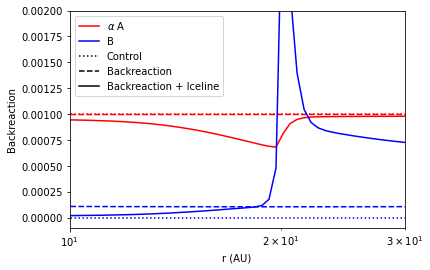

In [11]:
plt.figure()

plt.figure()
plt.xlim([10,30])
plt.ylim([-1.e-4,2.e-3])
plt.xlabel('r (AU)')
plt.ylabel(r'Backreaction')

A_control = sim_Control.dust.backreaction.A
A_backreaction = sim_Backreaction.dust.backreaction.A
A_iceline = sim_Backreaction_Iceline.dust.backreaction.A
B_control = sim_Control.dust.backreaction.B
B_backreaction = sim_Backreaction.dust.backreaction.B
B_iceline = sim_Backreaction_Iceline.dust.backreaction.B
alpha = sim_Control.gas.alpha

plt.semilogx(r/c.au, A_control * alpha, 'r:')
plt.semilogx(r/c.au, A_backreaction * alpha, 'r--')
plt.semilogx(r/c.au, A_iceline * alpha, 'r-')
plt.semilogx(r/c.au, B_control, 'b:')
plt.semilogx(r/c.au, B_backreaction, 'b--')
plt.semilogx(r/c.au, B_iceline, 'b-')

plt.semilogx(r/c.au, -np.ones_like(r),'r' ,label = r'$\alpha$ A')
plt.semilogx(r/c.au, -np.ones_like(r),'b' ,label = 'B')
plt.semilogx(r/c.au, -np.ones_like(r),'k:', label = 'Control')
plt.semilogx(r/c.au, -np.ones_like(r),'k--', label = 'Backreaction')
plt.semilogx(r/c.au, -np.ones_like(r),'k-' , label = 'Backreaction + Iceline')
plt.legend()



This plot show that in the `Backreaction + Iceline` simulation the backreaction coefficient B, that pushes the gas against the pressure gradient, dominates over the viscous spreading measured by $\alpha$ A (i.e. viscous spreading with backreaction damping)

In contrast, the `Backreaction` simulation without the iceline and a normal dust-to-gas ratio only shows a mild pushing coefficient, with $B \ll \alpha A$, which indicates that the evolution is mostly viscous.

We note that the backreaction effects only last while the dust continues to flow across the disk, and weakens if the dust-to-gas ratio decreases.